In [1]:
%load_ext autoreload
%autoreload 2
import sys
from os import path
import os


sys.path.insert(0, "../../")
sys.path.insert(0, "./")

from isanet.neural_network import MLPRegressor
from isanet.model import Mlp
from isanet.optimizer import SGD
from isanet.utils.model_utils import printMSE, printAcc, plotMse, save_data, load_data
from isanet.optimizer import EarlyStopping
from isanet.model_selection import Kfold, GridSearchCV
from isanet.metrics import mse, mee, accuracy_binary

import numpy as np
import time
import datetime
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [2]:
def plotCup(history):
    plt.plot(history["loss_mse"])
    plt.plot(history["val_loss_mse"], linestyle='--')
    plt.title('MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(['Training', 'Test'], loc='upper right', fontsize='large')
    plt.tight_layout()
    plt.show()

def plotCupCut(history, cut= 100):
    plt.plot(history["loss_mse"][cut:])
    plt.plot(history["val_loss_mse"][cut:], linestyle='--')
    plt.title('MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.xlim(left = cut)
    plt.grid()
    plt.legend(['Training', 'Test'], loc='upper right', fontsize='large')
    plt.tight_layout()
    plt.show()

def plotCupCutUnder(history, cut= 100):
    plt.plot(history["loss_mse"][:cut])
    plt.plot(history["val_loss_mse"][:cut], linestyle='--')
    plt.title('MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(['Training', 'Test'], loc='upper right', fontsize='large')
    plt.tight_layout()
    plt.show()

# dataset

Carico il dataset train+val e lo divido inizialmente in 75% per il training e 25% per il validation set

In [4]:
dataset = np.genfromtxt('../dataset/cup10/ML-CUP19-TR_tr_vl_10.csv',delimiter=',')
X_train = dataset[:1350,:-2] # 90%
Y_train = dataset[:1350,-2:]
    
X_val = dataset[1350:,:-2]   # 10%
Y_val = dataset[1350:,-2:]

X_train.shape

(1350, 10)

# init W, with bias = 0

MSE train: 0.7868380326185342 
MSE val: 0.9305558133556538 


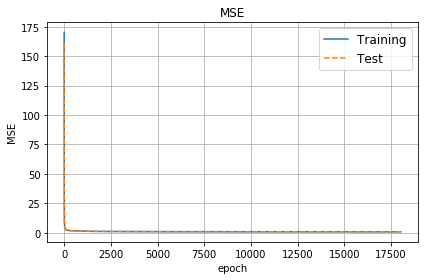

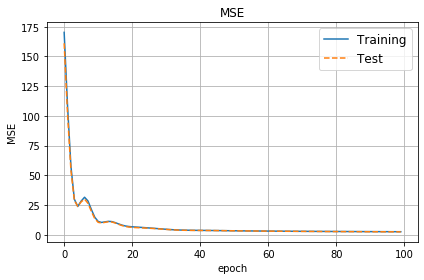

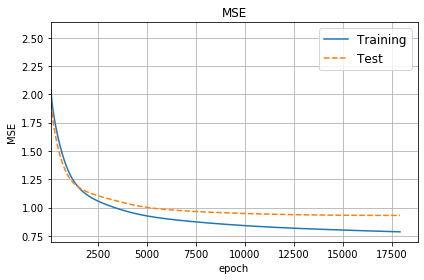

In [16]:
np.random.seed(seed=42)

param = {
            "n_layer_units": [50], # con questo si specifica la topologia da provare
            "learning_rate": 0.01,
            "momentum": 0.9,
            "nesterov": False,
            #"kernel_regularizer": 0.0001,
            "activation": "sigmoid",
            #"early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 25000
}

model = Mlp()
model.add(50, activation="sigmoid", input= 10, kernel_initializer = np.sqrt(6)/np.sqrt(20 +50), kernel_regularizer = 0.0001)
model.add(2, activation="linear", kernel_initializer = np.sqrt(6)/np.sqrt(50 + 2), kernel_regularizer = 0.0001)

model.weights[0][:,0] = 0
model.weights[1][:,0] = 0
model.set_optimizer(SGD(lr = 0.011, momentum = 0.9, nesterov = True))
es = EarlyStopping(0.0009, 20, verbose = False)

start_time = time.time()
model.fit(X_train,
            Y_train, 
            epochs=30000, 
            validation_data = [X_val, Y_val],
            es = es,
            verbose=0) 

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.history)
plotCupCutUnder(model.history)
plotCupCut(model.history)

MSE train: 0.7890263799962248 
MSE val: 0.9286350142276528 


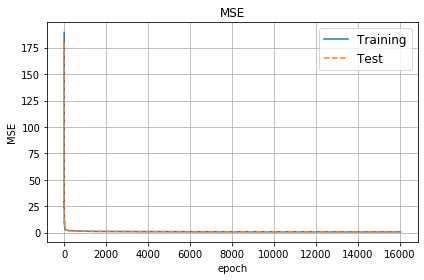

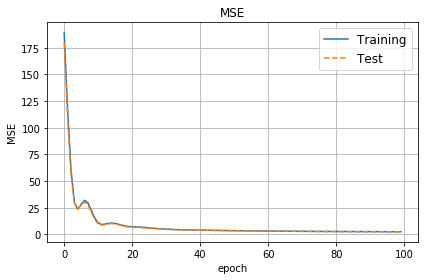

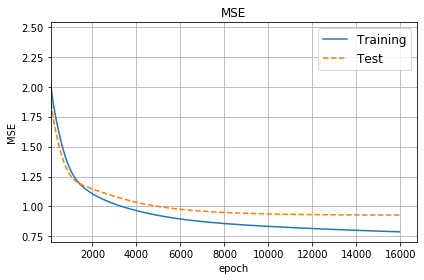

In [17]:
np.random.seed(seed=42)

param = {
            "n_layer_units": [50], # con questo si specifica la topologia da provare
            "learning_rate": 0.01,
            "momentum": 0.9,
            "nesterov": False,
            #"kernel_regularizer": 0.0001,
            "activation": "sigmoid",
            #"early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 25000
}

model = Mlp()
model.add(50, activation="sigmoid", input= 10, kernel_initializer = np.sqrt(6)/np.sqrt(20 +50), kernel_regularizer = 0.0001)
model.add(2, activation="linear", kernel_initializer = np.sqrt(6)/np.sqrt(50 + 2), kernel_regularizer = 0.0001)

model.set_optimizer(SGD(lr = 0.011, momentum = 0.9, nesterov = True))
es = EarlyStopping(0.0009, 20, verbose = False)

start_time = time.time()
model.fit(X_train,
            Y_train, 
            epochs=30000, 
            validation_data = [X_val, Y_val],
            es = es,
            verbose=0) 

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.history)
plotCupCutUnder(model.history)
plotCupCut(model.history)

# casi in overfitting

- test 1

MSE train: 0.7007790916870628 
MSE val: 0.8581609094436536 


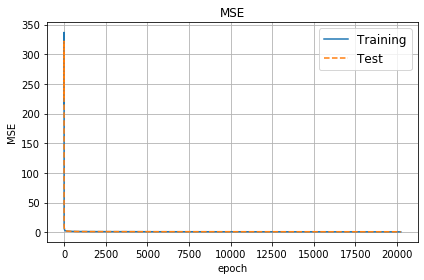

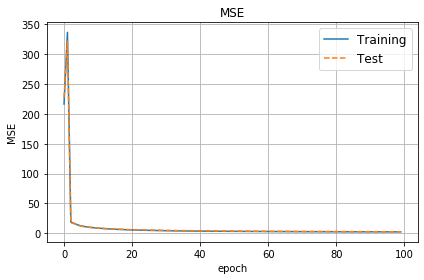

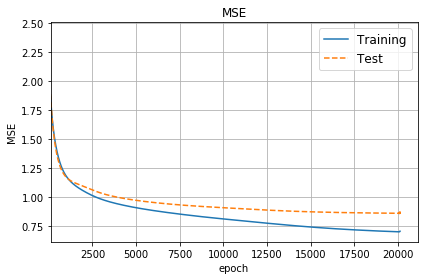

In [9]:
param = {
            "n_layer_units": [80], # con questo si specifica la topologia da provare
            "learning_rate": 0.098,
            "momentum": 0.2,
            "nesterov": True,
            "kernel_regularizer": 0.0001,
            "activation": "sigmoid",
            "early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 30000
}
model = MLPRegressor(X_train.shape[1], Y_train.shape[1], verbose = 0, **param)
model.fit(X_train, Y_train, X_val, Y_val)

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.get_history())
plotCupCutUnder(model.get_history())
plotCupCut(model.get_history())

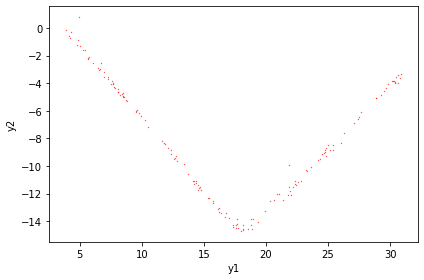

In [10]:
outputNet = model.predict(X_val)

plt.plot(outputNet[:,-2], outputNet[:,-1], 'ro', markersize=0.3)
plt.ylabel('y2')
plt.xlabel('y1')
plt.tight_layout()
plt.show()

MSE train: 0.7415742184074622 
MSE val: 0.9622037200101363 


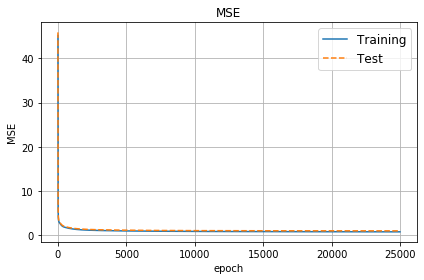

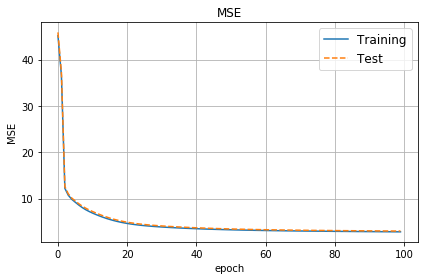

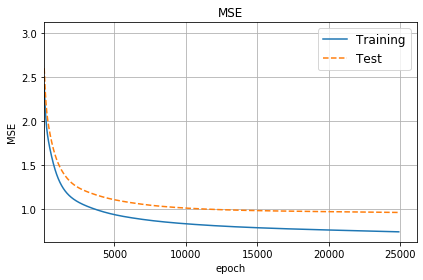

In [10]:
param = {
            "n_layer_units": [120], # con questo si specifica la topologia da provare
            "learning_rate": 0.04,
            "momentum": 0.6,
            "nesterov": True,
            #"kernel_regularizer": 0.0001,
            "activation": "sigmoid",
            #"early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 25000
}
model = MLPRegressor(X_train.shape[1], Y_train.shape[1], random_state = 42, verbose = 0, **param)
model.fit(X_train, Y_train, X_val, Y_val)

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.get_history())
plotCupCutUnder(model.get_history())
plotCupCut(model.get_history())

MSE train: 1.0652082222820438 
MSE val: 1.4421479527604808 


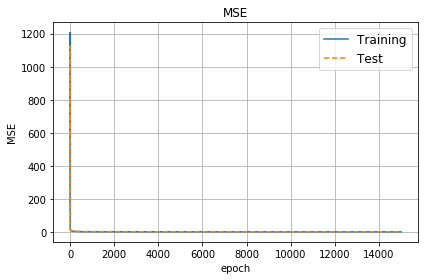

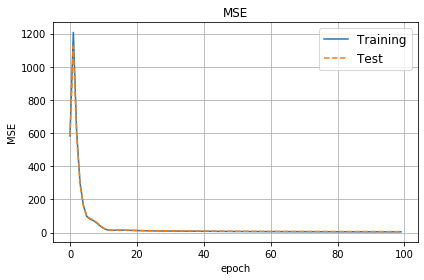

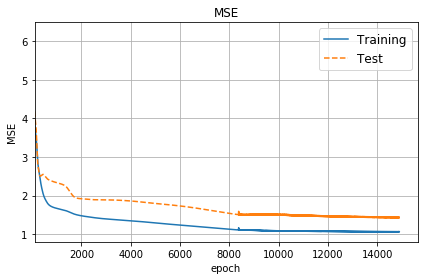

In [11]:
param = {
            "n_layer_units": [120], # con questo si specifica la topologia da provare
            "learning_rate": 0.09,
            "momentum": 0.8,
            "nesterov": True,
            #"kernel_regularizer": 0.0001,
            "activation": "sigmoid",
            #"early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 15000
}
model = MLPRegressor(X_train.shape[1], Y_train.shape[1], random_state = 42, verbose = 0, **param)
model.fit(X_train, Y_train, X_val, Y_val)

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.get_history())
plotCupCutUnder(model.get_history())
plotCupCut(model.get_history())

MSE train: 1.1500663473367474 
MSE val: 2.3996020114877594 


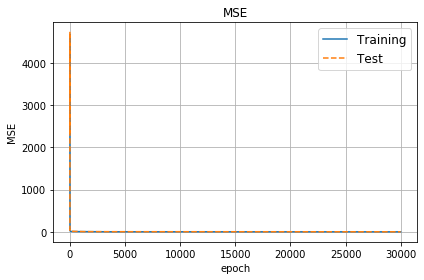

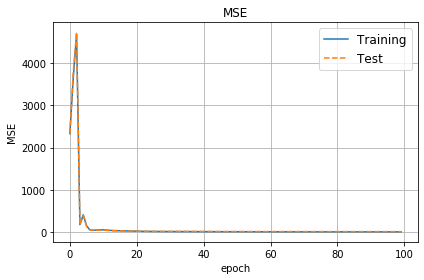

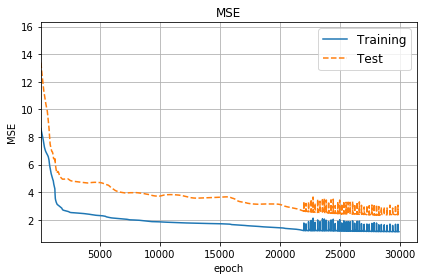

In [19]:
param = {
            "n_layer_units": [120], # con questo si specifica la topologia da provare
            "learning_rate": 0.15,
            "momentum": 0.8,
            "nesterov": True,
            #"kernel_regularizer": 0.0013,
            "activation": "sigmoid",
            #"early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 30000
}
model = MLPRegressor(X_train.shape[1], Y_train.shape[1], random_state = 42, verbose = 0, **param)
model.fit(X_train, Y_train, X_val, Y_val)

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.get_history())
plotCupCutUnder(model.get_history())
plotCupCut(model.get_history())

MSE train: 0.5464525535747807 
MSE val: 0.9756437218019194 


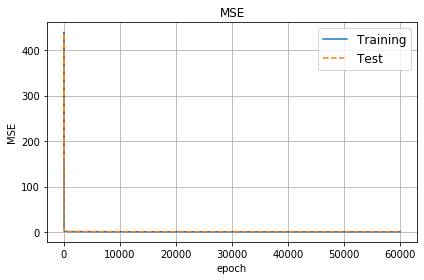

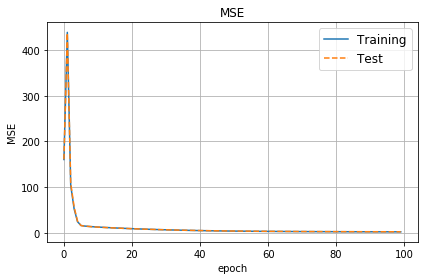

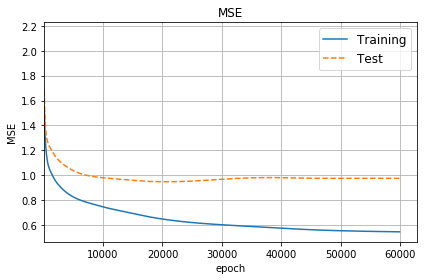

In [23]:
param = {
            "n_layer_units": [120], # con questo si specifica la topologia da provare
            "learning_rate": 0.06,
            "momentum": 0.6,
            "nesterov": True,
            #"kernel_regularizer": 0.0013,
            "activation": "sigmoid",
            #"early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 60000
}
model = MLPRegressor(X_train.shape[1], Y_train.shape[1], random_state = 42, verbose = 0, **param)
model.fit(X_train, Y_train, X_val, Y_val)

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.get_history())
plotCupCutUnder(model.get_history())
plotCupCut(model.get_history())

# fix overfitting with regularization

MSE train: 0.7681120162838759 
MSE val: 1.063781891281709 


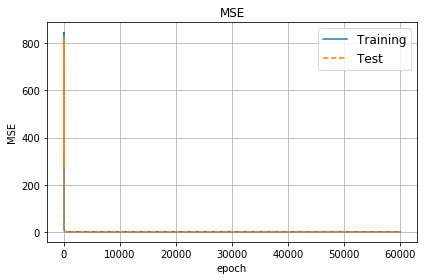

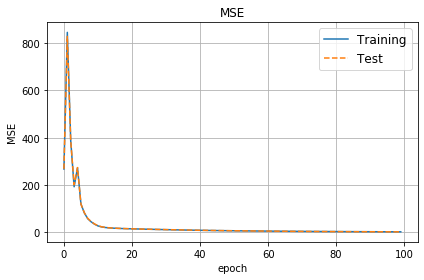

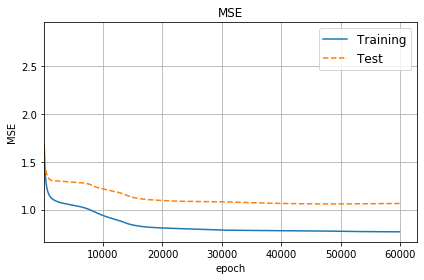

In [25]:
param = {
            "n_layer_units": [120], # con questo si specifica la topologia da provare
            "learning_rate": 0.07,
            "momentum": 0.6,
            "nesterov": True,
            "kernel_regularizer": 0.0001,
            "activation": "sigmoid",
            #"early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 60000
}
model = MLPRegressor(X_train.shape[1], Y_train.shape[1], random_state = 42, verbose = 0, **param)
model.fit(X_train, Y_train, X_val, Y_val)

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.get_history())
plotCupCutUnder(model.get_history())
plotCupCut(model.get_history())

# regularization can lead to underfitting

MSE train: 1.2012150901264604 
MSE val: 1.37554587701535 


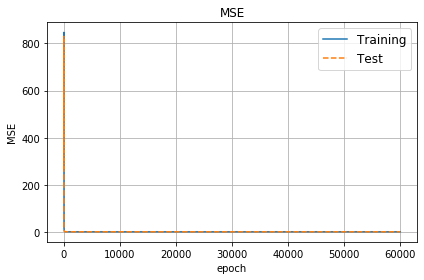

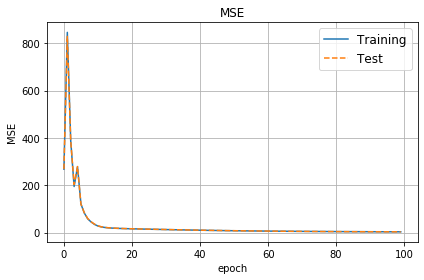

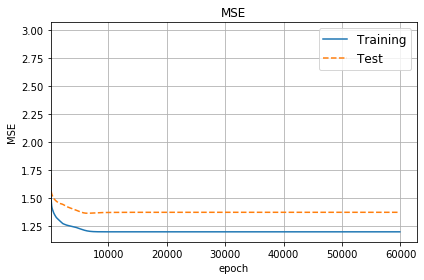

In [46]:
param = {
            "n_layer_units": [120], # con questo si specifica la topologia da provare
            "learning_rate": 0.07,
            "momentum": 0.6,
            "nesterov": True,
            "kernel_regularizer": 0.0018,
            "activation": "sigmoid",
            #"early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 60000
}
model = MLPRegressor(X_train.shape[1], Y_train.shape[1], random_state = 42, verbose = 0, **param)
model.fit(X_train, Y_train, X_val, Y_val)

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.get_history())
plotCupCutUnder(model.get_history())
plotCupCut(model.get_history())

# Early stopping

In [ ]:
param = {
            "n_layer_units": [50], # con questo si specifica la topologia da provare
            "learning_rate": 0.06,
            "momentum": 0.9,
            "nesterov": True,
            "kernel_regularizer": 0.00035,
            "activation": "sigmoid",
            "early_stop": EarlyStopping(0.09, 200),
            "max_epoch": 25000
}

model = MLPRegressor(X_train.shape[1], Y_train.shape[1], random_state = 42, verbose = 1, **param)
model.fit(X_train, Y_train, X_val, Y_val)

outputNet = model.predict(X_train)
printMSE(outputNet, Y_train, type = "train")

outputNet = model.predict(X_val)
printMSE(outputNet, Y_val, type = "val")

plotCup(model.get_history())
plotCupCutUnder(model.get_history())
plotCupCut(model.get_history())

# test su test

MSE TEST: 1.120995264095729
MEE TEST: 1.138698078241142


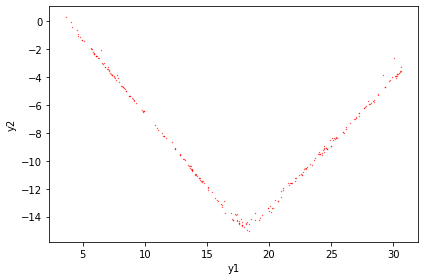

In [73]:
dataset = np.genfromtxt('../../../../CUP/cup10_tr_vl_ts_folds/ML-CUP19-TR_test_10.csv',delimiter=',')
X_test = dataset[:,:-2]
Y_test = dataset[:,-2:]
outputNet = model.predict(X_test)
print("MSE TEST: {}".format(mse(outputNet,Y_test)))
print("MEE TEST: {}".format(mee(outputNet,Y_test)))
plt.plot(outputNet[:,-2], outputNet[:,-1], 'ro', markersize=0.3)
plt.ylabel('y2')
plt.xlabel('y1')
plt.tight_layout()
plt.show()

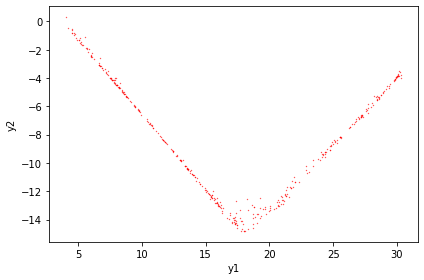

In [74]:
dataset = np.genfromtxt('../../../../CUP/ML-CUP19-TS.csv',delimiter=',')
ten_features = [1, 2, 3, 4, 5, 6, 7, 8, 12, 15]
X_test = dataset[:,ten_features]
outputNet = model.predict(X_test)

plt.plot(outputNet[:,-2], outputNet[:,-1], 'ro', markersize=0.3)
plt.ylabel('y2')
plt.xlabel('y1')
plt.tight_layout()
plt.show()